In [1]:
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
import pickle as pkl

from skimage.metrics import structural_similarity as ssim

import layers
import models
import utility as uty

from matplotlib import pyplot as plt
import functools

## GPUs

In [2]:
GPUs = '2'

uty.handle_GPUs(GPUs=GPUs, enable_GPU=1,)

tf_mirror_strategy = tf.distribute.MirroredStrategy()

print('tf version: ', tf.version.VERSION)

number of Logical GPUs: 1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
tf version:  2.7.0


2023-09-01 12:06:15.791675: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 12:06:16.227927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:41:00.0, compute capability: 8.0


In [3]:
class Model_with_layer_search(tf.keras.Model):
    
    def __init__(self, inputs, outputs, **kwargs):
        
        super(Model_with_layer_search, self).__init__(inputs, outputs, **kwargs)
        self.w_init = self.get_weights()
        pass
    
    # extract one layer
    def get_layer_by_name(self, name):
        
        """
        returns the layer with specified name.
        
        name: name of the layer to return
        """
        
        return self._get_layer_by_name(name)
    
    def _get_layer_by_name(self, name, model=None, _found_layer=None):
        
        """
        return the layer with the desired exact name.
        !!! Always give "_found_layer=None".
        !!! Give "model=None" to search the current model. 
        """
        
        if _found_layer is not None:
            return _found_layer
        
        else:
            if model is None:
                model = self

            for l in model.layers:
                if not('.Functional' in str(l)):
                    if l.name==name:
                        return l
                else:
                    _found_layer = self._get_layer_by_name(name, l, _found_layer)
                    if _found_layer:
                        break
        return _found_layer
    
    def re_initialize(self, seed=None, Initializer=tf.keras.initializers.GlorotUniform):
        
        """
        The model is re-initialized with the initial random weights.
        If seed is not None or is 0, the weights are randomly drawn with that seed from Gloriotd init.
        """
        
        w_new = self.w_init
        if seed is not None and seed!=0:
            ini = Initializer(seed=seed)
            for i, w_tmp in enumerate(w_new):
                w_new[i] = ini(np.shape(w_tmp), dtype=tf.float32)
        
        self.set_weights(w_new)
        pass
    
    @staticmethod
    def rotate_corners(im):
        """
        Splits the image in 4 windows and rotates them by 180°.

        This enambles to visualize the mask coherentely
        with our paper and with the original paper or LOUPE.
        """

        def rot180(inp):
            return np.rot90(np.rot90(inp))

        row = np.shape(im)[0]//2
        col = np.shape(im)[1]//2

        im[:row,:col] = rot180(im[:row,:col])
        im[:row,col:] = rot180(im[:row,col:])
        im[row:,:col] = rot180(im[row:,:col])
        im[row:,col:] = rot180(im[row:,col:])

        return im
    
    def get_layer_by_name_with_functionals(self, name, model=None):
        if model is None:
            model = self
        
        l_list = self._get_layer_by_name_with_functionals(name, model)
    
        if l_list is None:
            raise ValueError('Layer not found.')
        else:
            return l_list + [model]
    
    def _get_layer_by_name_with_functionals(self, name, model=None, _found_layer=None):
        
        """
        return the layer with the desired exact name.
        !!! Always give "_found_layer=None".
        !!! Give "model=None" to search the current model. 
        """
        
        for l in model.layers:
            if '.Functional' in str(l):
                
                _found_layer = self._get_layer_by_name_with_functionals(name, l, _found_layer)
                
                if _found_layer:
                    _found_layer += [l]
                    break
                
            else:
                if l.name==name:
                    return [l]
                
        return _found_layer
    
    
    def get_functional_input_name(self, layer, model=None):
        
        """
        Returns the inputs of "layer" within "model"
        layer: the layer to analyze
        model: the model where to search
        """
        
        if model is None:
            model = self
    
        # type, or class name of the layer
        l_class = str(type(layer)).split('.')[-1][:-2]
        
        # input layers have no inputs
        if l_class=='InputLayer':
            return []

        # aggregates lines of text (read from summary)
        def print_fn(x, summary):
            summary += [x]

        # initialize the variable storing the summary
        summary = []
        line_length = 200
        
        # store the summary in the variable "summary"
        model.summary(line_length=line_length, print_fn=lambda x: print_fn(x, summary))
        
        ##### extract info from summary
        
        # the index at which inputs are listed
        bias = summary[2].find('Connected to')
        
        # join all summary lines in one line
        summary = ''.join(summary)
        
        # sequential model
        if bias==-1:
            
            start_ind_inp = summary.find(f' {layer.name} ({l_class})')
            for i in range(1, 10):
                ind = start_ind_inp + 1 - i*line_length
                if summary[ind]!=' ':
                    return [summary[ind: summary.find(' (', ind)] + '[0][0]']
                    
            
        else: # the model is not sequential
                        
            # finds the layer in the summary
            start_ind_inp = summary.find(f' {layer.name} ({l_class})') + bias + 2

            # if no inputs are used for this layer
            if summary[start_ind_inp-1]==']':
                inp_name_list = []

            # if the layer has layers
            else:
                ##### search for the inputs
                stop_ind_inp = summary.find("'", start_ind_inp)
                inp_name_list = [summary[start_ind_inp: stop_ind_inp]]

                # search until all inputs are found
                while summary[stop_ind_inp+1]==',':
                    start_ind_inp += line_length
                    stop_ind_inp = summary.find("'", start_ind_inp)
                    inp_name_list += [summary[start_ind_inp: stop_ind_inp]]
            
        return inp_name_list
    
    @staticmethod
    def to_list(x):
        
        """
        returns a list if the input is not a list
        """
        
        if type(x) is not list:
            x = [x]
        return x
    
    @staticmethod
    def from_list(x):
        
        """
        returns the element of a list that only has one element, 
        otherwise does nothing.
        """
        
        if type(x) is list and len(x)==1:
            x = x[0]
        return x
    
    def _modify(self, model, modifier, layers_modified=None, name_target_layers=None,
                name_outputs_to_remove=None, clone=False, keep_weights=False, 
                propagate_new_layer_outputs_to_model_output=False, index_propagation=None, **kwargs):
        
        """
        'model': the model where to use substitute the layer.
        'modifier': operation to be done with the layer. Function of str.
                    possible str keyword: "add", "substitute". The firts adds the layer
        'layers_modified': layers that will substitute the layer with the same name.
        'name_target_layers': the name of the layer in the model, that when found activates "modifier",
                              if None it assumes the layer to search has the same name as "layers_modified"
        'name_outputs_to_remove': the name of the outputs that will not be included in the model outputs.
        'clone': whether to return an independent model or not. Dependent models share the weights.
        'keep_weights': if model is clone, whether to keep the weights or re-initialize it.
        'propagate_new_layer_outputs_to_model_output': whether to include the new layer output in the model output.
        'index_propagation': what output to include. If None, all outputs of the layer are used.
        'kwargs': used as inputs for modifier.
        """

        if layers_modified is None and name_target_layers is None:
            raise ValueError('specity "name_taget_layers", or provide "layers_modified" ',
                             'and their name will be used as target layers names')
        
        if type(modifier)==str:
            if modifier not in ['add', 'addition', 'substitute', 'substitution']:
                raise ValueError('enter a valid modifier key words, or eneter a valid modifier function.',
                                 'valid keywords: "add", "substitute".')
        
        if name_outputs_to_remove is None:
            name_outputs_to_remove = []
        
        # check if modifier is a keywork and retrieve the modifier from default ones.
        if modifier=='substitute' or modifier=='substitution':
            modifier = self.modifier_substitute_layer
        elif modifier=='add' or modifier=='addition':
            modifier = self.modifier_add_layer
        
        # adjust data types.
        layers_modified = self.to_list(layers_modified)
        if index_propagation is not None:
            index_propagation = self.to_list(index_propagation)
        
        # names of layers to substitue
        if name_target_layers is None:
            name_target_layers = [o.name for o in layers_modified]

        # get the input names of all the layers in the model
        dict_input = {}
        for l in model.layers:
            # get input name of one layer
            dict_input[l.name] = self.get_functional_input_name(l, model)
        
            
        _names_all_inputs = [i for j in dict_input.values() for i in j]
        
        # remove duplicated from list
        names_all_inputs = []
        [names_all_inputs.append(n) for n in _names_all_inputs if n not in names_all_inputs]
        
        # list containing the name of the model outputs
        # initialize the list with the name of original outputs
        final_output_name_list = [o.name for o in self.to_list(model.output) 
                                  if o.name not in name_outputs_to_remove]
        
        
        # dict containing outputs of all layers indexed by layer name
        dict_tensors = {}
        
        # dict containing outputs of all layers indexed by output name
        dict_model_output = {}
        
        # gather all inputs
        list_model_inputs = []
        
        # loop over all layers of model
        for l in model.layers:
            
            # type, or class name, of the layer
            l_class = str(type(l)).split('.')[-1][:-2]

            # if the layer is an InputLayer no need for an input
            if l_class=='InputLayer':
                outputs_l = self.to_list(l.output)
                list_model_inputs += outputs_l
                
                # loop over all outputs of the input layer (usually just one)
                for j, o in enumerate(outputs_l):
                    
                    dict_tensors[f'{l.name}[0][{j}]'] = o
                    dict_model_output[o.name] = o
                    
            # if layer is not an InputLayer
            else:
                
                ##### handle multiple calls of the same layer by creating multiple inputs
                # index of the number of times the layer is called
                i = -1
                
                # all inputs of the layer; inputs are removed the when used 
                # next layer is considered when all inputs have been used
                _input_name_list = dict_input[l.name]
                
                # store all inputs ordered in sublists; every sublist is for a 
                # single call of the layer 
                output_name_list = []
                
                # loop until all inputs have been used
                while _input_name_list:
                    
                    # initialize the sublist of inputs for a single layer call
                    output_name_sublist = []
                    
                    # update the index of the layer call
                    i = i+1
                    
                    # loop over all inputs that have been used yet
                    for _o in _input_name_list:
                        
                        # if an input is the result of this current layer call at a further iteration
                        # or it has already been considered, the sublist is completed. Go to next call
                        if _o.find(f'{l.name}[{i}]')>=0 or _o in output_name_sublist:
                            break
                        
                        # add input to current sublist
                        output_name_sublist += [_o]
                    
                    # store sublist
                    output_name_list += [output_name_sublist]
                    
                    # remove used inputs from list
                    [_input_name_list.remove(r) for r in output_name_sublist]
                    
                    
                    
                
                ##### call layer
                # (handles multiple layer calls)
                
                # loop over all input sublists (usually len=1; len>1 if multiple calls).
                for i, output_name in enumerate(output_name_list):
                    
                    inputs_l = [dict_tensors[o_name] for o_name in output_name]                
                                        
                    # check if the layer is the target one
                    if l.name in name_target_layers:
                        
                        # first layer call
                        if i==0:
                            # get new layer
                            l_modified = layers_modified[name_target_layers.index(l.name)]
                        
                        outputs_l, final_output_name_list = modifier(
                            l, inputs_l, l_modified, i, len(output_name_list)-1, 
                            propagate_new_layer_outputs_to_model_output,
                            final_output_name_list, index_propagation, **kwargs)
                    
                    else:
                        # call the layer and get results
                        outputs_l = self.to_list(l(self.from_list(inputs_l)))
                    
                    ##### store outputs
                    # loop over all layer outputs
                    for j, o in enumerate(outputs_l):
                        
                        # handle previous multi layer calls, by storing tensors with correct index.
                        # implementation: search in the list of all inputs what is the first missing
                        
                        str_0, str_1 = f'{l.name}[', f'][{j}]'
                        len_0, len_1 = len(str_0), len(str_1)
                        
                        list_tmp = [n for n in names_all_inputs if (n[:len_0]==str_0 and n[-len_1:]==str_1)]
                        
                        # this tensor is used as an input
                        if list_tmp!=[]:
                            
                            index_l_call = min([int(n[len_0: n.find(']', len_0)]) for n in list_tmp])

                            
                            dict_tensors[f'{l.name}[{index_l_call}][{j}]'] = o
                            
                            # update the list of missing input tensors names
                            for n in names_all_inputs:
                                if (n[:len_0]==str_0 and f'[{index_l_call}]' in n[len_0-1:-len_1+1] and n[-len_1:]==str_1):
                                    names_all_inputs.remove(n)
                        
                        # store layer outputs
                        dict_model_output[o.name] = o
                        
            pass
        
        # new outputs
        outputs_model = [dict_model_output[o_name] for o_name in final_output_name_list]

        ##### order the inputs as the original model
        original_input_name = [i.name for i in model.inputs]
        list_model_input_name = [i.name for i in list_model_inputs]
        list_model_inputs_ordered = list_model_input_name
        for i in list_model_inputs:
            ind = original_input_name.index(i.name)
            list_model_inputs_ordered[ind] = i
            
        # create the model with new outputs
        model = type(model)(list_model_inputs_ordered, outputs_model, name=model.name)
        

        # clone and preserve weights
        if clone==True:
            if keep_weights==True:
                w_old = model.get_weights()
            model = tf.keras.models.clone_model(model)

            if keep_weights==True:
                model.set_weights(w_old)

        return model

    def modifier_substitute_layer(self, 
                                  l,
                                  inputs, 
                                  layer_modified, 
                                  index_call=0,
                                  max_index_call=0, 
                                  propagate_new_layer_outputs_to_model_output=False,
                                  final_output_name_list=None,
                                  index_propagation=None,):
        
        if propagate_new_layer_outputs_to_model_output and final_output_name_list is None:
            raise ValueError('provide "final_output_name_list" if propagate outputs is active.')

        # call the layer and get results
        outputs = self.to_list(layer_modified(self.from_list(inputs)))

        # last layer call
        if index_call==max_index_call and propagate_new_layer_outputs_to_model_output:

            # include new layer outputs to model output (not if already included)
            name_o = [o.name for o in outputs if o.name not in final_output_name_list]

            # check which outputs to include based on user specification
            if index_propagation is not None:
                name_o = [n for ind, n in enumerate(name_o) if ind in index_propagation]
            
            final_output_name_list += name_o
            
        return outputs, final_output_name_list
    
    def modifier_add_layer(self, 
                           l,
                           inputs, 
                           layer_modified, 
                           index_call=0,
                           max_index_call=0, 
                           propagate_new_layer_outputs_to_model_output=False,
                           final_output_name_list=None,
                           index_propagation=None,):
        
        if propagate_new_layer_outputs_to_model_output and final_output_name_list is None:
            raise ValueError('provide "final_output_name_list" if propagate outputs is active.')
        
        # call the layer and get results
        outputs = self.to_list(l(self.from_list(inputs)))

        # last layer call
        if index_call==max_index_call:
            
            old_output_shape = [o.shape for o in outputs]
                        
            outputs = self.to_list(layer_modified(self.from_list(outputs)))
            
            new_outputs_shape = [o.shape for o in outputs]
            
            # check compatibility of the new layer (matching number of outputs and shapes)
            _and = lambda x, y: a & y
            if len(new_outputs_shape)<len(old_outputs_shape):
                
                # the first outputs of the new layer must have same shape as the outputs of previous layer,
                # The new layer may have more outputs than the previous layer, but compatibility is not affceted.
                seq_shape = [i==j for i, j in zip(old_outputs_shape, new_outputs_shape)]
                if not (functools.reduce(_and, seq_shape)):
                    raise ShapeError('The new layer must have the same number of outputs as its previous layer. ',
                                     'Also, the shapes of all the new and previous layer outputs must match.')
                
            if propagate_new_layer_outputs_to_model_output:

                # include new layer outputs to model output, if not already included
                name_o = [o.name for o in outputs if o.name not in final_output_name_list]

                # check which outputs to include based on user specification (if provided)
                if index_propagation is not None:
                    name_o = [n for ind, n in enumerate(name_o) if ind in index_propagation]

                final_output_name_list += name_o
            
        return outputs, final_output_name_list
        
    
    
    def propagate_layer_outputs(self,
                                name_layer,
                                index_propagation=None,
                                keep_old_outputs=True,
                                clone=False,
                                keep_weights=False):
        
        """
        Takes the outputs of "layer" and propagates them through 
        the nested sequence of layers till they become outputs of the model.
        
        Args:
            name_layer: list of layer names whose outputs will be propagated
            model: the model where to search the layer. If None, this istance is used
            index_propagation: select which outputs to propagate by indexing. If None, all outputs are taken
            keep_old_outputs: whether to keep or remove original outputs
            clone: whether to return a deep dopy or not
            keep weights: if "clone==True", whether it mantains the same weights as the original model.
        Outputs:
            A model with new propagated outputs, the same type as the input model.
        """
        
        name_old_outputs = None
        if not keep_old_outputs:
            name_old_outputs = [o.name for o in self.outputs]
        
        return self.modify_model(name_layer, 'substitute', self, True, 
                                 name_old_outputs,
                                 index_propagation, clone, keep_weights)
        
        
        
    def modify_model(self,
                     name_target_layers,
                     modifier,
                     model=None,
                     propagate_outputs=False,
                     name_outputs_to_remove=None,
                     index_propagation=None,
                     clone=False,
                     keep_weights=False, 
                     **kwargs):

        """
        name_target_layers: when the layer with this name is found, the modifier acts
        modifier: action to take. Can be a function or can be a keyword: "add" or "substitute".
        model: if None, self is used
        propagate_outputs: whether to propagate the outputs of the selected layer of not
        name_outputs_to_remove: list of names of the outputs of the model to remove
        index_propagation: if layers have multiple outputs and certain should be considered, e.g., [[0, 4], [1]]
        clone: whether to return an independent model or not. Dependent models share the weights.
        keep_weights: if model is clone, whether to keep the weights or re-initialize it.
        """

        # handle index propagation
        if propagate_outputs:
            if index_propagation is not None:
                index_propagation = self.to_list(index_propagation)
                if len(index_propagation)!=len(name_target_layers):
                    raise ValueError('index_propagation is a list of lists with len equal to name_target_layers')
            else:
                index_propagation = [index_propagation]*len(name_target_layers)
                
        name_target_layers = self.to_list(name_target_layers)
        
        if model is None:
            model = self
            
        _name_outputs_to_remove = None
        
        for i, (n_target, ind_prop) in enumerate(zip(name_target_layers, index_propagation)):

            # layer path to the specified layer
            l_list = model.get_layer_by_name_with_functionals(n_target)
            
            model = self._modify(
                l_list[1], modifier, l_list[0], n_target, 
                name_outputs_to_remove=None,
                propagate_new_layer_outputs_to_model_output=propagate_outputs, 
                index_propagation=ind_prop,
                **kwargs)
            
            name_m_outputs = [o.name for o in model.outputs]
            name_l_outputs = [o.name for o in self.to_list(l_list[0].output)]
            ind_prop = [name_m_outputs.index(nl) for nl in name_l_outputs]
            
            for j, l in enumerate(l_list[2:]):

                if i==len(name_target_layers)-1 and j==len(l_list[2:])-1:
                    _name_outputs_to_remove = name_outputs_to_remove

                model = self._modify(
                    l, 'substitute', model, name_outputs_to_remove=_name_outputs_to_remove, 
                    propagate_new_layer_outputs_to_model_output=propagate_outputs,
                    index_propagation=index_propagation)
                
                name_m_outputs = [o.name for o in model.outputs]
                name_l_outputs = [o.name for o in self.to_list(l.output)]
                index_propagation = [name_m_outputs.index(nl) for nl in name_l_outputs]
                    
            pass
        
        # clone the model
        if clone==True:
            
            if keep_weights==True:
                w = model.get_weights()
                pass
            
            model = tf.keras.models.clone_model(model)
            if keep_weights==True:
                model.set_weights(w)
            pass
        
        return model

In [4]:
class Model_enc_dec(Model_with_layer_search):
    
    """
    A class for incremental MRI
    
    It has the Dykstra and the Masker included
    You can add the self-assessment to it
    You can get a model with all the desired sub-results (or default)
    """
    
    def __init__(self, 
                 inputs=None,
                 outputs=None,
                 input_shape=None,
                 R=None,
                 masker=None,
                 sequence_type='unconstrained', 
                 iterations_dykstra=10,
                 data_augmentation=False,
                 mode='train',
                 name='enc_dec',
                 **kwargs):
        
        """
        If you have already have the model structure, provide "inputs" and "outputs",
        otherwise provide "R" and "masker" and the standard architecture is used.
        
        The masker and the mask have lower freq in the centre. 
        The keras model works with lower freq in the corners, so setter and getter are used.
        
        """
        
        if ((inputs is None or outputs is None) and input_shape is None):
            raise ValueError('provide a model structure with "inputs" and "outputs" ',
                             'or provide at least "input_shape", and the structure is created inside')
        
        if mode != 'train' and mode != 'test':
            raise ValueError('mode can take only "train" or "test"')
            
        if inputs is None or outputs is None:            
            # make sure masker is compliant
            if masker is not None:
                masker = self.rotate_corners(np.array(masker))
                
            if R is None:
                R=1.0
            
            inputs, outputs = self.get_model_structure(
                input_shape,
                R,
                masker,
                sequence_type, 
                iterations_dykstra,
                data_augmentation)
            
        super(Model_enc_dec, self).__init__(inputs, outputs, name=name, **kwargs)
                
        self.mode = mode
        self.data_augmentation = data_augmentation
        
        pass
        
    @property
    def R(self):
        return self.get_layer_by_name('prob_mask_scaled').R
    @R.setter
    def R(self, R):
        self.get_layer_by_name('prob_mask_scaled').R = tf.cast(R, tf.float32)
        pass
    
    @property
    def sequence_type(self,):
        return self.get_layer_by_name('prob_mask').sequence_type
    @sequence_type.setter
    def sequence_type(self, sequence_type):
        self.get_layer_by_name('prob_mask').sequence_type = sequence_type
        self.get_layer_by_name('random_mask').sequence_type = sequence_type
        pass
    
    # handle inner masker representation
    @property
    def masker(self):
        masker = self.get_layer_by_name('masker').read_masker()
        return self.rotate_corners(np.array(masker))
    @masker.setter
    def masker(self, masker):
        masker = self.rotate_corners(np.array(masker))
        self.get_layer_by_name('masker').write_masker(masker)
        pass
    
    # handle probability mask inner mask representation
    @property
    def prob_mask(self):
        """
        Returns the probability mask (values from 0 to 1).
        To get the real value prob_mask (before sigmoid) get to the layer "prob_mask"
        then call the method "layer.read_probMask(True)"
        """
        prob_mask = self.get_layer_by_name('prob_mask').read_probMask()
        return self.rotate_corners(np.array(prob_mask))
    @prob_mask.setter
    def prob_mask(self, prob_mask):
        """
        Set the probability mask by taking the probality mask (values from 0 to 1).
        To set the real valued (before sigmoid) prob_mask use the layer method 
        "layer.read_probMask(True)".
        """
        prob_mask = self.rotate_corners(np.array(prob_mask))
        self.get_layer_by_name('prob_mask').set_probMask(prob_mask)
        pass
    
    # handle inner mask representation
    @property
    def mask(self):
        mask = np.array(self.prob_mask)>0.5
        masker = np.array(self.masker)
        return mask*masker
    @mask.setter
    def mask(self, mask):
        raise ValueError('to be programmed')
        # take the mask and retrieve the model parameters to retrieve the prob_mask
        # then set the prob_mask
        pass
    
    # prevent wrong mode assignement
    @property
    def mode(self):
        return self._mode
    @mode.setter
    def mode(self, mode):
        self.set_mode(mode)
        pass
    
    # retrieve model inputs and outputs
    @staticmethod
    def get_model_structure(input_shape,
                            R,
                            masker=None,
                            sequence_type='unconstrained', 
                            iterations_dykstra=10, 
                            data_augmentation=False):
        
        """
        static method
        
        Get the stanrdard accelerated MRI autoencoder structure, i.e., inputs and outputs.
        if masker is None, then it is all 1, e.i, is an irrelevant layer.
        """
        
        # input
        tensor_input = tf.keras.Input(input_shape, name='input_enc_dec')
        
        tensor = tensor_input
        
        # data augmentation
        if data_augmentation:
            submodel_augmentation = models.data_augmentation(input_shape)
            tensor = submodel_augmentation(tensor)
        
        # enc
        submodel_enc = models.enc_mri(input_shape,
                                      R,
                                      masker=masker,
                                      sequence_type=sequence_type)
        tensor_mask, tensor_z = submodel_enc(tensor)

        # dec
        submodel_dec = models.dec_mri(tensor_z.shape[1:])
        tensor_x_bar = submodel_dec(tensor_z)

        # measurement constraint + Dykstra
        submodel_mc = models.measure_constraint_mri(tensor_x_bar.shape[1:],
                                                    tensor_mask.shape[1:],
                                                    iterations_dykstra)
        tensor_x_hat = submodel_mc([tensor_x_bar, tensor_z, tensor_mask])
        
        tensor_output = tensor_x_hat
        
        # data augmentation
        if data_augmentation:
            submodel_mae = models.mae_standard(tensor.shape[1:])
            tensor_output = submodel_mae([tensor, tensor_output])
            
        return tensor_input, tensor_output
    
    # whetehr model should be trained or tested
    def set_mode(self, mode):
        """
        mode can take "train" or "test", 
        if "mode==train" masks are random and undersampling is with soft threshold;
        if "mode==test" masks are fixed and undersampling is with hard threhsold.
        """
        
        if mode!="train" and mode!="test":
            raise ValueError('mode can take "test" or "train"')
        
        if mode=='test':
            maxval = 0.50000001
            minval = 0.49999999
            hard_threshold = True
        else:
            maxval = 1
            minval = 0
            hard_threshold = False

        self._set_mode_recursive(self, maxval, minval, hard_threshold)
        self._mode = mode
        pass
    
    def _set_mode_recursive(self, model, maxval, minval, hard_threshold):
        
        """
        !!! It is safer to call this function via the method "set_mode(...)"
        Recursively checks all the layers of the model and sets 1) all "random_mask" layers
        attributes "maxval" and "minval"; 2) all "undersample" layers attributes
        "hard_threshold".
        """
        
        for l in model.layers:
            if not('.Functional' in str(l)):
                if 'random_mask' in l.name:
                    l.set_attributes(maxval = maxval, minval = minval)

                elif 'undersample' in l.name:
                    l.set_attributes(hard_threshold = hard_threshold)
            else:
                self._set_mode_recursive(l, maxval, minval, hard_threshold)

        pass
    
    
    def fit_safe(self, x, y, mode='train', **kwargs):
        
        """
        Normal "fit" function, but the new arg "mode" lets the user specify the mode.
        """
        
        if mode!='current' and self.mode!=mode:
            self.mode=mode
        return super(Model_enc_dec, self).fit(x, y, **kwargs)
    
    def evaluate_safe(self, x, y, mode='test', **kwargs):
        if self.mode!=mode:
            self.mode=mode
        return super(Model_enc_dec, self).evaluate(x, y, **kwargs)
    
    def predict_safe(self, x, mode='test', **kwargs):
        if self.mode!=mode:
            self.mode=mode
        return super(Model_enc_dec, self).predict(x, **kwargs)      

In [5]:
class Model_self_assessment(Model_with_layer_search):
    
    """
    A self assessment class for incremental MRI.
    """
    
    def __init__(self, 
                 inputs=None,
                 outputs=None,
                 input_shape=None,
                 name='self_assessment',
                 line_coef=None,
                 **kwargs):
        
        """
        If you have already have the model structure, provide "inputs" and "outputs",
        otherwise provide "input_shape", in the form of the original image shape.
        """
        
        if ((inputs is None or outputs is None) and input_shape is None):
            raise ValueError('provide a model structure with "inputs" and "outputs" ',
                             'or provide at least "input_shape", and the structure is created inside')
        
        if inputs is None or outputs is None:
            
            inputs, outputs = self.get_model_structure(
                input_shape[:-1]+(2,),
                input_shape, 
                line_coef=line_coef)            
            
        super(Model_self_assessment, self).__init__(inputs, outputs, name=name, **kwargs)
        
        pass
        
    @staticmethod
    def get_line_coef(pred, true, poly_degree, higher_degree_first=True):
        
        coef = np.polyfit(pred, true, poly_degree)[::-1]
        
        if higher_degree_first:
            coef = coef[::-1]
        
        return coef
        
    @staticmethod
    def get_model_structure(input_shape_z,
                            input_shape_x,
                            line_coef=None,
                            filt=[10,8,6,4,2,1],
                            kern=[5]*6,
                            pool_size=[(2, 2)]*6,
                            average_pooling=True,
                            poly_degree=2,
                            name='self_assessment'):
        
        """
        if inputs=[tensor_z, tensor_x_bar, tensor_x_hat, tensor_m] is provided it is used,
        if it not provided, the shapes are used to create new tensor inputs.
        """

        tensor_z = tf.keras.Input(input_shape_z, name='input_z')
        tensor_x_bar = tf.keras.Input(input_shape_z, name='input_x_bar')
        tensor_x_hat = tf.keras.Input(input_shape_x, name='input_x_hat')
        tensor_m = tf.keras.Input(input_shape_x, name='input_mask')
        
        inputs = [tensor_z, tensor_x_bar, tensor_x_hat, tensor_m]
        
        # mae
        submodel_mae = models.mae_mri(input_shape_z, input_shape_x, layer_x_mod='fft')
        tensor_mae = submodel_mae([tensor_z, tensor_m, tensor_x_bar])    
        
        # self-assessment
        submodel_self_assessment = models.model_self_assessment(
                input_shape_x, 
                tensor_mae.shape[1:],
                line_coeff=line_coef,
                filt=filt,
                kern=kern,
                pool_size=pool_size,
                average_pooling=average_pooling,
                poly_degree=poly_degree,
                name=name,
            )
        tensor_q = submodel_self_assessment([tensor_x_hat, tensor_mae])
        
        return [tensor_z, tensor_x_bar, tensor_x_hat, tensor_m], tensor_q

In [6]:
class Manager_incremental():
    
    """
    Stores important path for Incremental training.
    """
    
    def __init__(self, 
                 working_dir,
                 dataset,
                 sequence_type,
                 R_list,
                 R=None,
                 redundancy=0,
                 incremental_id=None):
        
        """
        R_list: list of all R to be used in incremental.
        get_model_enc_dec: function to get the model for undersampling and reconstructing.
        get_model_self_assessment: function to get the model for quality estimation.
        redundancy: number of models to train contemporarily (only best is kept).
        """
        
        if sequence_type not in ['unconstrained', 'cartesian_rows', 'cartesian_columns']:
            raise ValueError("'sequence_type' is not valid. Enter one between",
                             " 'unconstrained', 'cartesian_rows', 'cartesian_columns'.")
            
        if incremental_id is None:
            incremental_id = ''
            
        if R is None:
            R = R_list[0]
            
        self.id = self.get_id(dataset, sequence_type, incremental_id)
        
        self.working_dir = working_dir
        self.dataset = dataset
        self.R_list = np.sort(R_list)
        self.R = R
        self.sequence_type = sequence_type
        self.redundancy = redundancy
        self.incremental_id = incremental_id
        
        self.create_path()
        
        pass
    
    @staticmethod
    def get_id(dataset, sequence_type, incremental_id):
        if incremental_id!='' and incremental_id[0]!='-':
            incremental_id = '-'+incremental_id
        return f'{dataset}-{sequence_type}{incremental_id}'
    
    def create_path(self,):
        
        for R_tmp in R_list:
            path_R = self.get_main_path(R_tmp)
            
            for model_str in ['enc_dec', 'self_assessment']:
                
                os.makedirs(os.path.join(path_R, model_str, 'weights'), exist_ok=True)
                
                for i in range(self.redundancy+1):
                    for j in ['tensorboard', os.path.join('checkpoint', 'checkpoint.ckpt')]:
                        os.makedirs(os.path.join(path_R, model_str, f'redundancy_{i}', j), exist_ok=True)
                
        pass
    
    def get_main_path(self, R):
        return os.path.join(self.working_dir, self.id, str(R))
    
    # R
    @property
    def R(self, ):
        return self._R
    @R.setter
    def R(self ,R):
        if R not in self.R_list:
            raise ValueError('R must be in R_list')
        self._R = R
        pass
    
    # main_path
    @property
    def main_path(self):
        return self.get_main_path(self.R)
    
    # main_path for ed or sa
    @property
    def path_ed(self):
        return os.path.join(self.get_main_path(self.R), 'enc_dec')
    @property
    def path_sa(self):
        return os.path.join(self.get_main_path(self.R), 'self_assessment')
    
    # weights
    @property
    def path_ed_weights(self):
        return os.path.join(self.path_ed, 'weights')
    @property
    def path_sa_weights(self):
        return os.path.join(self.path_sa, 'weights')
    
    
    def check_index_redundancy(self, index_redundancy):
        if index_redundancy is None and self.redundancy==0:
            i = 0 
        elif index_redundancy>=0 and index_redundancy<=self.redundancy:
            i = index_redundancy
        else:
            raise ValueError('"index_redundancy" is not valid.')
        return i
    
    # tensorboard
    def get_path_ed_tensorboard(self, index_redundancy=0):
        i = self.check_index_redundancy(index_redundancy)
        return os.path.join(self.path_ed, f'redundancy_{i}', 'tensorboard')
    def get_path_sa_tensorboard(self, index_redundancy=0):
        i = self.check_index_redundancy(index_redundancy)
        return os.path.join(self.path_sa, f'redundancy_{i}', 'tensorboard')

    # checkpoint
    def get_path_ed_checkpoint(self, index_redundancy=None):
        i = self.check_index_redundancy(index_redundancy)
        return os.path.join(self.path_ed, f'redundancy_{i}', 'checkpoint', 'checkpoint.ckpt')
    def get_path_sa_checkpoint(self, index_redundancy=0):
        i = self.check_index_redundancy(index_redundancy)
        return os.path.join(self.path_sa, f'redundancy_{i}', 'checkpoint', 'checkpoint.ckpt')
    
    def get_callbacks(self, 
                      model_str, 
                      index_redundancy=None,
                      factor_reduction_LR=0.2,
                      patience_LR=40, 
                      patience_early=60,
                      min_lr=1e-5):
        
        if model_str=='enc_dec':
            path_checkpoint=self.get_path_ed_checkpoint(index_redundancy)
            path_tensorboard=self.get_path_ed_tensorboard(index_redundancy)
        elif model_str=='self_assessment':
            path_checkpoint=self.get_path_sa_checkpoint(index_redundancy)
            path_tensorboard=self.get_path_sa_tensorboard(index_redundancy)
        else:
            raise ValueError("'model_str' can only take 'enc_dec' or 'self_assessment'")
        
        callbacks = [
            tf.keras.callbacks.TerminateOnNaN(),
            
            tf.keras.callbacks.ReduceLROnPlateau(factor=factor_reduction_LR,
                                                 patience=patience_LR,
                                                 min_lr=min_lr),
            
            tf.keras.callbacks.EarlyStopping(patience=patience_early,
                                             restore_best_weights=True),
            
            tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                               save_best_only=True,
                                               save_weights_only=True),
            
            tf.keras.callbacks.TensorBoard(log_dir=path_tensorboard)]
        
        return callbacks

In [7]:
class Model_edsa(Model_with_layer_search):

    def __init__(self, ed, sa, metric='mae', alias_outputs_ed=None, alias_inputs_sa=None, name='sa_advanced', extended_ed=False):

        """
        Connects ed and sa models, useful for advanced sa training and for post-sa.
        Args:
            ed: a model for enc_dec, with all outputs necessary for connection with sa
            sa: a model for self_assessment.
            metric: the metric the "sa" predicts, that is computed on the fly and used as label.
                    Avalilable keywords are "mae", "mse", "ssim". Otherwise pass a layer/model.
            alias_outputs_ed: an alternative name for ed outputs (matching output order). 
                              Defoult, output names.
                              It must contain "x_hat", i.e., the reconstructed image.
            alias_inputs_sa: an alternative name for sa inputs (matching output order). 
                             Defoult, inputs names (prefix "input_" is automatically removed if present).
            extended_ed: whether to use ed as a list of layers or as a functional. 
                         Set this to True for easier "post_sa"; Recommended: False.

        The connections between ed and sa are created based on matching alias names.
        """
        
        input_shape = ed.inputs[0].shape[1:]
        
        if type(metric) is str:
            if metric=='mae':
                metric = models.mae_standard(input_shape)
            elif metric=='mse':
                metric = models.mse_standard(input_shape)
            elif metric=='ssim':
                metric = models.ssim_standard(input_shape)   
            else:
                raise ValueError('eneter a valid keyword: "mae", "mse" or "ssim".')
        
        self.extended_ed = extended_ed
        
        self.name_ed = ed.name
        self.name_sa = sa.name

        if alias_outputs_ed is None:
            alias_outputs_ed = [o.name.split('/')[-2] for o in ed.outputs]

        if alias_inputs_sa is None:
            alias_inputs_sa = [i.name.replace('input_', '') for i in sa.inputs]
            
        if extended_ed:
            inputs_ed = ed.inputs
            outputs_ed = ed.outputs

        else:
            inputs_ed = tf.keras.Input(input_shape, name='input_edsa')
            outputs_ed = ed(inputs_ed)
            
        # re-order outputs ed based on the order of input list of model sa
        inputs_sa = [outputs_ed[alias_outputs_ed.index(a)]
                     for a in alias_inputs_sa]
            
        # call self assessment 
        q_hat = sa(inputs_sa)

        # get reconstructed image
        x_hat = outputs_ed[alias_outputs_ed.index('x_hat')]

        # assuming the input is the ground truth image
        x = self.from_list(inputs_ed)

        # compute ground-truth quality
        q = metric([x, x_hat])
        
        qs = tf.keras.layers.Concatenate(name='concatenate_q')([q, q_hat])
        
        # prepare the output
        # qs = tf.keras.layers.Subtract(name='subtract_q')([q, q_hat])

        return super(Model_edsa, self).__init__(inputs=inputs_ed, outputs=qs, name=name)

    def get_ed(self, ):
        if self.extended_ed:
            raise ValueError('to use this function "extended_ed" must be False.')
        return self.get_layer(self.name_ed)
    
    def get_sa(self, ):
        return self.get_layer(self.name_sa)
    
    def fit_sa_safe(self, x, y, **kwargs):
        
        self.get_ed().mode = 'test'
        self.get_ed().trainable = False
        
        # self.get_sa().trainable = True
        
        super(Model_edsa, self).fit(x, y, **kwargs)

In [8]:
def get_f_augmentation(input_shape, zoom=0.1, rotation=0.05, flip=True, seed=5435, labels_augmentation=False):
    
    """
    input_shape: the shape of the input image
    zoom: zooming factor
    rotation: rotation factor
    flip: whether to flip
    seed: seed for the random operations
    labels_augmentation: whether to replicate the same augmentation to the labels or not 
                         (recommended True for autoencoders)
    """
    
    t_input = tf.keras.Input(input_shape)
    
    t = t_input
    
    if zoom:
        t = tf.keras.layers.RandomZoom(zoom, zoom, seed=seed, fill_mode='constant')(t)
    if flip:
        t = tf.keras.layers.RandomFlip(seed=seed)(t)
    if rotation:
        t = tf.keras.layers.RandomRotation(rotation, seed=seed, fill_mode='constant')(t)
    
    seq_data_augmentation = tf.keras.Model(t_input, t, name='augmentation')

    if labels_augmentation:
        f_augmentation = lambda x, y: (seq_data_augmentation(x, training=True), 
                                       seq_data_augmentation(y, training=True))
    else:
        f_augmentation = lambda x, y: (seq_data_augmentation(x, training=True), y)
    
    return f_augmentation

In [9]:
def refine_ds(ds, batch_size, shuffle=True, buffer_size=1000, data_augmentation=False, augmentator=None):
    
    if data_augmentation==True and augmentator is None:
        raise ValueError('if "data:augmentation" is True, provide a valid "augmentator"')
    
    ds =  (
        ds
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    
    if shuffle:
        ds = ds.shuffle(buffer_size)
    
    if data_augmentation:
        ds = ds.map(augmentator)
        
    return ds

In [10]:
def psnr(y_true, y_pred):
    return tf.math.reduce_mean(tf.image.psnr(y_true, y_pred, 1))

class Psnr_edsa(tf.keras.losses.Loss):
    
    def tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))  
        return numerator / denominator

    def call(self, y_true, y_pred):
        mae = tf.math.abs(y_true - y_pred)
        mae = 20*self.tf_log10(1/mae+1e-7)
        return tf.reduce_mean(mae)

class Mae_edsa(tf.keras.losses.MeanAbsoluteError):
    
    def call(self, _, y_pred):
        return super(Mae_edsa, self).call(y_pred[..., 0], y_pred[..., 1])
    
class Mse_edsa(tf.keras.losses.MeanSquaredError):
    
    def call(self, _, y_pred):
        return super(Mse_edsa, self).call(y_pred[0], y_pred[1])
        
    
def mae(real, pred):
    axis = (-1, -2)
    if np.shape(real)[-1] in [1, 2]:
        axis = axis + (-3, )

    return np.mean(np.abs(real-pred), axis=axis)

def mse(real, pred):
    axis = (-1, -2)
    if np.shape(real)[-1] in [2, 1]:
        axis = axis + (-3, )
    return np.mean((real-pred)**2, axis=axis)

def var(real, pred):
    axis = (-1, -2)
    if np.shape(real)[-1] in [2, 1]:
        axis = axis + (-3, )
    return np.var(real-pred, axis=axis)

def my_ssim(real, pred):

    return [ssim(r, p, data_range=1, multichannel=True) for r, p in zip(real, pred)]

def ifft(im):
    im = im[... ,0] + 1j*im[..., 1]
    im = np.fft.ifft2(im)
    return np.concatenate((np.real(im)[..., np.newaxis], np.imag(im)[..., np.newaxis]), -1)

def fft(im):
    im = im[... ,0] + 1j*im[..., 1]
    im = np.fft.fft2(im)
    return np.concatenate((np.real(im)[..., np.newaxis], np.imag(im)[..., np.newaxis]), -1)

In [11]:
def to_PSNR(metric, eps = 1e-7):
    return 10 * np.log10(1/(metric+eps))
def to_PSNR_mae(metric, eps = 1e-7):
    return 2*to_PSNR(metric, eps)

## General parameters

In [12]:
R_list = [4.0, 6.0, 8.0]
dataset = 'IXI'
sequence_type = 'unconstrained'

loss = 'mae'

folder = 'poppe'

redundancy = 0

In [13]:
manager = Manager_incremental(folder, dataset, sequence_type, R_list, redundancy=redundancy)

## Load Data

In [14]:
xdata, vdata, tdata = uty.load_dataset(dataset=dataset)

lx = len(xdata)
lv = len(vdata)

xdata_ed = xdata[lx//2:]
vdata_ed = vdata[lv//2:]

xdata_sa = xdata[:lx//2]
vdata_sa = vdata[:lv//2]

input_shape = np.shape(xdata_ed)[1:]

print(f'shape xdata_ed = {np.shape(xdata_ed)}')
print(f'shape vdata_ed = {np.shape(vdata_ed)}')
print(f'shape xdata_sa = {np.shape(xdata_sa)}')
print(f'shape vdata_sa = {np.shape(vdata_sa)}')
print(f'shape tdata = {np.shape(tdata)}')

shape xdata_ed = (12450, 256, 256, 1)
shape vdata_ed = (825, 256, 256, 1)
shape xdata_sa = (12450, 256, 256, 1)
shape vdata_sa = (825, 256, 256, 1)
shape tdata = (1200, 256, 256, 1)


## Training parameters

In [15]:
batch_size=128
epochs=1000
lr = 1e-3

In [16]:
advanced_sa_training = True

poly_degree_sa = 2

In [17]:
names_layers_additional_outputs = ['d_clip', 'undersample', 'add', 'masker']
name_files_subresults_sa = ['x_hat', 'z', 'x_bar', 'mask']

save_subresults_for_sa = False
masker = None

data_augmentation_ed = True
data_augmentation_sa = True

## Dataset

In [18]:
xds_ed = tf.data.Dataset.from_tensor_slices((xdata_ed, xdata_ed))
vds_ed = tf.data.Dataset.from_tensor_slices((vdata_ed, vdata_ed))

tds = tf.data.Dataset.from_tensor_slices((tdata, tdata))

In [19]:
xds_edsa = tf.data.Dataset.from_tensor_slices((xdata_sa, np.zeros((len(xdata_sa), 1))))
vds_edsa = tf.data.Dataset.from_tensor_slices((vdata_sa, np.zeros((len(vdata_sa), 1))))

tds_edsa = tf.data.Dataset.from_tensor_slices((tdata, np.zeros((len(tdata), 1))))

In [20]:
f_augmentation = get_f_augmentation(input_shape, labels_augmentation=True)
f_augmentation_edsa = get_f_augmentation(input_shape)

In [21]:
xds_ed = refine_ds(xds_ed, batch_size, shuffle=True, 
                   data_augmentation=data_augmentation_ed,
                   augmentator=f_augmentation)
vds_ed = refine_ds(vds_ed, batch_size, shuffle=False)

tds = refine_ds(tds, batch_size, shuffle=False)

xds_edsa = refine_ds(xds_edsa, batch_size, shuffle=True, 
                     data_augmentation=data_augmentation_sa,
                     augmentator=f_augmentation_edsa)
vds_edsa = refine_ds(vds_edsa, batch_size, shuffle=False)
tds_edsa = refine_ds(tds_edsa, batch_size, shuffle=False)

## Training

In [22]:
for R in R_list:
    
    print(f'\t\t\t--- R={R} ---\n\n')
    
    manager.R = R
    
    evaluation_best = np.infty
    
    path_weights = os.path.join(manager.path_ed_weights, 'weights')
    
    with tf_mirror_strategy.scope():
        model_ed = Model_enc_dec(input_shape=input_shape, R=R, masker=masker, 
                                 sequence_type=sequence_type, 
                                 data_augmentation=False)
        
        model_ed.compile(tf.keras.optimizers.Adam(lr), loss, metrics=[psnr])
        
    if (os.path.isdir(manager.path_ed_weights) and
        os.path.isfile(os.path.join(manager.path_ed_weights, 'checkpoint')) and 
        os.path.isfile(os.path.join(manager.path_ed_weights, 'weights.index')) ):
        
        model_ed.load_weights(path_weights)
        print('loaded weights, skip training')
    
    else:
    
        for index_redundancy in range(redundancy+1):

            # model.re_initialize(seed=index_redundancy)
            callbacks=manager.get_callbacks('enc_dec', index_redundancy=index_redundancy)

            path_ckpt = manager.get_path_ed_checkpoint(index_redundancy)
            if (os.path.isdir(path_ckpt) and
                os.path.isfile(os.path.join(os.path.dirname(path_ckpt), 'checkpoint'))):
                
                model_ed.load_weights(path_ckpt)
                
                print('loaded weights from checkpoint')
            
            model_ed.fit_safe(x=xds_ed, y=None,
                              batch_size=batch_size, epochs=epochs,
                              verbose=2, callbacks=callbacks, validation_data=vds_ed)

            evaluation = model_ed.evaluate_safe(vdata_sa, y=None, return_dict=True, batch_size=batch_size)['loss']
            if evaluation<evaluation_best:
                w = model_ed.get_weights()

        model_ed.set_weights(w)
        model_ed.save_weights(path_weights)
    
    masker = model_ed.mask
    
    print('evaluation on tdata')
    model_ed.evaluate_safe(tds, None, batch_size=batch_size, verbose=2)
    
    ##### advanced sa training
    
    if advanced_sa_training:
        
        path_weights_edsa = os.path.join(manager.path_sa_weights, 'weights')
        
        print('model_ed_more creation') 
        # access intermediate outputs
        model_ed_more = model_ed.propagate_layer_outputs(
            names_layers_additional_outputs, 
            keep_old_outputs=True)
        
        print('model_ed_more prediction') 
        pred = model_ed_more.predict_safe(xdata_sa, batch_size=batch_size, verbose=False)
        
        # re-order outputs ed based on name list provided by user
        name_outputs_ed = [o.name.split('/')[-2] for o in model_ed_more.outputs]
        alias_outputs_ed = [name_files_subresults_sa[names_layers_additional_outputs.index(n)]
                            for n in name_outputs_ed]
        
        x_hat = pred[alias_outputs_ed.index('x_hat')]
        x_bar = pred[alias_outputs_ed.index('x_bar')]
        z = pred[alias_outputs_ed.index('z')]
        
        print('data_preparation')
        # get data for computing line coef (for self assessment)
        x_bar = x_bar[..., 0] + 1j*x_bar[..., 1]
        x_bar = np.fft.fft2(x_bar)[..., np.newaxis]
        x_bar = np.concatenate((np.real(x_bar), np.imag(x_bar)), axis = -1)
        
        x_bar = x_bar * np.repeat(np.repeat(masker[np.newaxis], len(x_bar), 0), 2, -1)
        mae_pred = mae(z, x_bar)
        mae_true = mae(xdata_sa, x_hat) 
        
        print('line coef')
        line_coef = Model_self_assessment.get_line_coef(mae_pred, mae_true, 
                                                        poly_degree_sa, 
                                                        higher_degree_first=True)
        
        print(line_coef)
        
        with tf_mirror_strategy.scope():
            model_sa = Model_self_assessment(input_shape=input_shape, 
                                             line_coef=line_coef)
        
        alias_inputs_sa = [i.name.replace('input_', '') for i in model_sa.inputs]
        
        with tf_mirror_strategy.scope():
            model_edsa = Model_edsa(model_ed_more, model_sa, 
                                    loss, alias_outputs_ed, alias_inputs_sa)
            if loss=='mae':
                loss_edsa = Mae_edsa()
            elif loss=='mse':
                loss_edsa = Mse_edsa()
            else:
                raise ValueError('to be implemented')
                
            model_edsa.compile(tf.keras.optimizers.Adam(lr), loss_edsa)
            
        if (os.path.isdir(manager.path_sa_weights) and
            os.path.isfile(os.path.join(manager.path_sa_weights, 'checkpoint')) and 
            os.path.isfile(os.path.join(manager.path_sa_weights, 'weights.index')) ):

            model_edsa.load_weights(path_weights_edsa)
            print('loaded weights, skip training')

        else:
            
            evaluation_best = np.infty
            
            for index_redundancy in range(redundancy+1):

                # model.re_initialize(seed=index_redundancy)
                callbacks=manager.get_callbacks('self_assessment', index_redundancy=index_redundancy)

                path_ckpt = manager.get_path_sa_checkpoint(index_redundancy)
                if (os.path.isdir(path_ckpt) and
                    os.path.isfile(os.path.join(os.path.dirname(path_ckpt), 'checkpoint'))):

                    model_edsa.load_weights(path_ckpt)

                    print('loaded weights from checkpoint')

                model_edsa.fit_sa_safe(x=xds_edsa, y=None,
                                       batch_size=batch_size, epochs=epochs,
                                       verbose=2, callbacks=callbacks,
                                       validation_data=vds_edsa)

                evaluation = model_edsa.evaluate(vds_sa, None, return_dict=True)['loss']
                if evaluation<evaluation_best:
                    w = model_edsa.get_weights()

            model_edsa.set_weights(w)
            model_edsa.save_weights(path_weights_edsa)

        print('evaluation edsa on tdata')
        model_edsa.evaluate(tds_edsa, None, verbose=2)
        
    if save_subresults_for_sa:
        model_ed_more = model_ed.propagate_layer_outputs(names_layers_additional_outputs, keep_old_outputs=False)
        
        output_names = [o.name.split('/')[-2] for o in model_ed_more.outputs if '/' in o.name]
        
        if name_files_subresults_sa is None:
            name_files_subresults_sa = output_names
        else:
            # ordering the file names based on output order
            name_files_subresults_sa = [
                name_files_subresults_sa[names_layers_additional_outputs.index(n)] 
                for n in output_names]
                
        q, qm_fft, qm_ifft = {}, {}, {}
        
        for x, data_str in zip([xdata_sa, vdata_sa, tdata],
                               ['xdata', 'vdata', 'tdata']):
            
            data_pred = model_ed_more.predict_safe(x)
            
            # exclude the outputs that are not included in the list of specified outputs
            _or = lambda x, y: x | y
            data_pred = [d for d, n in zip(data_pred, [o.name for o in model_ed_more.outputs]) 
                         if functools.reduce(_or, [a in n for a in names_layers_additional_outputs])]
            
            print('computing "q"')
            # q = MAE(x_hat, x)
            x_hat = data_pred[name_files_subresults_sa.index('x_hat')]
            q['mae'] = mae(x, x_hat)
            q['mse'] = mse(x, x_hat)
            q['var'] = var(x, x_hat)
            q['ssim'] = my_ssim(x, x_hat)
            
            print('computing "q_measurement_fft"')
            # q_measurement_fft = MAE(F[x_bar], z)
            x_bar = data_pred[name_files_subresults_sa.index('x_bar')]
            z = data_pred[name_files_subresults_sa.index('z')]
            fx_bar = fft(x_bar)
            qm_fft['mae'] = mae(z, fx_bar)
            qm_fft['mse'] = mse(z, fx_bar)
            qm_fft['var'] = var(z, fx_bar)
            qm_fft['ssim'] = my_ssim(z, fx_bar)
            
            print('computing "q_measurement_ifft"')
            # q_measurement_fft = MAE(x_bar, iF(z))
            zf = ifft(z)
            qm_ifft['mae'] = mae(zf, x_bar)
            qm_ifft['mse'] = mse(zf, x_bar)
            qm_ifft['var'] = var(zf, x_bar)
            qm_ifft['ssim'] = my_ssim(zf, x_bar)
            
            print('storing')
            
            data_pred += [q, qm_fft, qm_ifft]
            name_files_subresults_sa += ['q', 'qm_fft', 'qm_ifft']
            
            # loop over multiple outputs of the same model
            for n, d in zip(name_files_subresults_sa, data_pred):
                
                path_result = os.path.join(manager.main_path, f'{data_str}_sa_{n}.pkl')
                
                # if result is already stored, no need for restoring.
                if not os.path.isfile(path_result):
                    
                    print('\t', n)
                    # store data
                    with open(path_result, 'wb') as f:
                        pkl.dump(d, f)

			--- R=4.0 ---


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I

2023-09-01 12:09:15.891155: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1200
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:2"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 1
        }

10/10 - 12s - loss: 0.0013 - psnr: 53.3813 - 12s/epoch - 1s/step
model_ed_more creation
model_ed_more prediction
data_preparation
line coef
[-2.22466515e-05  4.90538417e-04  2.70991344e-04]
loaded weights, skip training
evaluation edsa on tdata


2023-09-01 12:10:52.801318: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1200
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}



10/10 - 5s - loss: 3.2949e-04 - 5s/epoch - 454ms/step
			--- R=6.0 ---


loaded weights, skip training
evaluation on tdata


2023-09-01 12:10:59.107445: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1200
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:2"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 1
        }

10/10 - 5s - loss: 0.0024 - psnr: 49.4994 - 5s/epoch - 496ms/step
model_ed_more creation
model_ed_more prediction
data_preparation


KeyboardInterrupt: 

## Results

In [24]:
# to get the reconstructed image x_hat:
x_hat = model_ed.predict(tds)

plt.imshow(x_hat[np.random.randint(0, len(tdata))], cmap='gray', vmin=0, vmax=1);

2023-09-01 10:22:30.702498: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1200
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:2"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 1
        }

Instructions for updating:
use `experimental_local_results` instead.


In [25]:
# to get the real and predicted q:
qs = model_edsa.predict(tds_edsa)
q, q_hat = qs[..., 0], qs[..., 1]

2023-08-28 08:38:58.813611: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1200
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}



Instructions for updating:
use `experimental_local_results` instead.


In [26]:
line_coef_2 = model_sa.get_layer_by_name('linear_reg_dense').get_weights()
print(line_coef)
print(line_coef_2)

[ 0.01103323 -0.01024837  0.08918015]
[array([[0.00455946],
       [0.00060343]], dtype=float32), array([0.00651506], dtype=float32)]


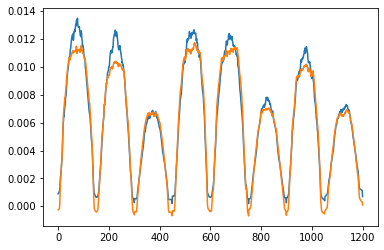

In [30]:
plt.plot(q)
plt.plot(q_hat)
# plt.title(np.mean(np.abs(to_PSNR_mae(q)-to_PSNR_mae(q_hat))));

In [50]:
qP = np.nan_to_num(to_PSNR_mae(q), nan=100)
q_hatP = np.nan_to_num(to_PSNR_mae(q_hat), nan=100)


/tmp/ipykernel_283924/3692216389.py:2: RuntimeWarning: invalid value encountered in log10
  return 10 * np.log10(1/(metric+eps))


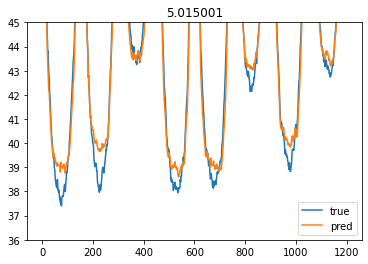

In [53]:
plt.plot(qP, label='true')
plt.plot(q_hatP, label='pred')
plt.title(np.mean(np.abs(qP-q_hatP)));
plt.ylim(36, 45)
plt.legend();